<h1>Chapter 5: Support Vector Machines</h1>
A <em>Support Vector Machine</em> is a powerful and versatile Machine Learning model, capable of performing linear or nonlinear classification, regression, and even novelty detection. SVMs shine with small to medium-sized nonlinear datasets (i.e. hundreds to thousands of instances), especially or classification tasks. However, they don't scale well to very large datasets.

<h2>5.1 Linear SVM Classification</h2>

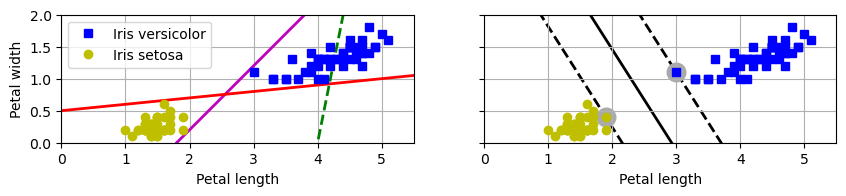

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=1e100)
svm_clf.fit(X, y)

# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5 * x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

plt.show()

The above plot shows part of the iris dataset. The two classes can be separated easily with a straight line (they are linearly separable). The left plot shows the decision boundaries of three possible linear classifiers. The model whose decision boundary is represented by the dashed line is so bad that it doesn't even separate the classes properly. The other two models work perfectly on this training set, but their decision boundaries come so close to the instances that these models will probably not perform as well on new instances. In constrast, the solid line in the plot on the right represents the decision boundary of an SVM classifier; this line not only separates the two classes but also stays as far away from the closest training instance as possible. 

You can think of an SVM classifier as fitting the widest possible street (represented by the parallel dashed lines) between the classes. This is called <em>large margin classification</em>. 

Adding more training instances "off the street" will not affect the decision boundary at all: it is fully determined by instances located on the edge of the street. These instances are called the <em>support vectors</em>. These are circled on the right plot.

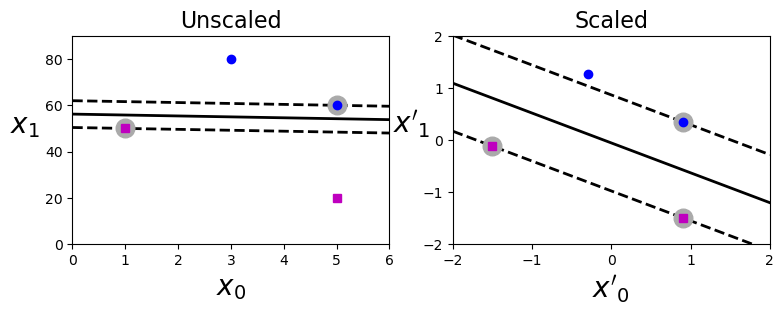

In [6]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x'_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])
plt.show()

SVMs are sensitive to feature scales. In the left plot, the vertical scale is much larger than the horizontal scale, so the widest possible street is close to horizontal. After scaling features, the decision boundary in the right plot looks much better.

<h2>5.2 Soft Margin Classification</h2>

If we strictly impose that all instances must be off the street and on the correct side, this is called <em>hard margin classification</em>. There are two main issues with hard margin classification. Firstly, it only works if the data is linearly separable. Second, it is sensitive to outliers.

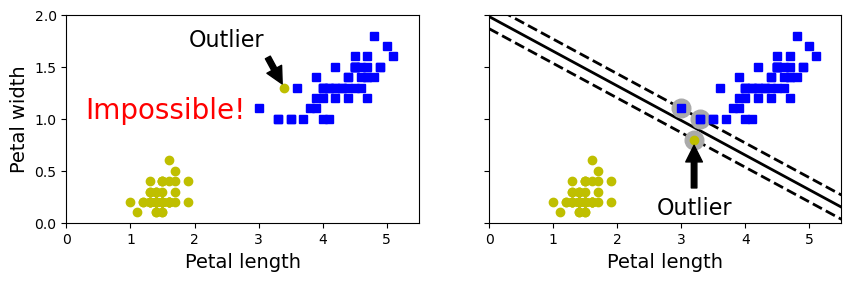

In [8]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=20, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.show()

The above plot shows the iris dataset with just one additional outlier: on the left, it's impossible to find a hard margin; on the right, the decision boundary ends up very different from the one we saw previously without the outlier, and the model will probably not generalise as well. 

To avoid these issues, we need to use a more flexible model. The objective is to find a good balance between keeping the street as large as possible and limiting the <em>margin violations</em> (i.e. instances that end up in the middle of the street or on the wrong side). This is called <em>soft margin classification</em>.

When creating an SVM model using Scikit-Learn, you can specify several hyperparameters, including the regularisation hyperparameter C. Reducing C makes the street larger, but it also leads to more margin violations. In other words, reducing C results in more instances supporting the street, so there's less risk of overfitting. But if you reduce it too much, then the model ends up underfitting. 

In [13]:
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris(as_frame = True)

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y  = (iris.target == 2)

svm_clf = make_pipeline(StandardScaler(), LinearSVC(C = 1, random_state = 42))

svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, random_state=42))])

In [14]:
X_new = [[5.5, 1.7], [5.0, 1.5]]

svm_clf.predict(X_new)

array([ True, False])

In [15]:
svm_clf.decision_function(X_new)

array([ 0.66163411, -0.22036063])

Unlike Logistic Regression, LinearSVC doesn't have a predict_proba() method to estimate the class probabilities. That said, if you use the SVC class instead of LinearSVC, and if you set its probabilities hyperparameter to True, then the model will fit an extra model at the end of training to map the SVM decision function scores to estimated probabilities. 

Under the hood, this requires 5-fold cross-validation to generate out-of-sample predictions for every instance in the training set, then training a LogisticRegression model, so it will slow training considerably. After that, the predict_proba() and predict_log_proba() methods will be available.